<a href="https://colab.research.google.com/github/jatinrai/Data-Science/blob/master/Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Modelling


In [2]:
%pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.8 MB/s eta 0:00:00


In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima

import pandas_datareader.data as web
import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
plt.rcParams['figure.figsize'] = [10, 5]

## 1. Model

###  Non-Stationarity Time Series
We will try to model non-stationary time-series data and try to forecast the future data points.

## 2. Datasets

### 2.1 Microsoft Daily Close Price
We analysed the 3 year historical closing price data for the tech giant Microsoft traded on NASDAQ.  
Applying the augmented Dickey–Fuller (ADF),  
we conclude that the dataset is non-stationary.

 ADF p-value: 0.7169258645317884


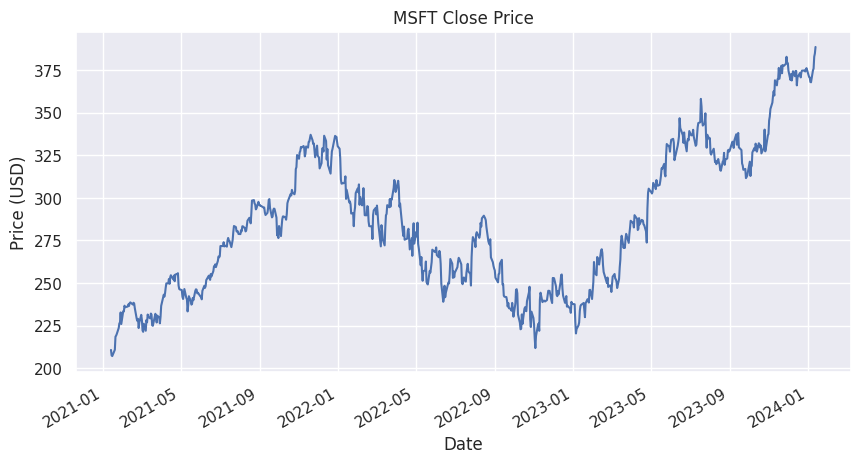

In [2]:
msft = yf.Ticker('MSFT').history(period='3y')['Close']

print(' ADF p-value:', adfuller(msft)[1])

msft.plot()
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('MSFT Close Price')
plt.show()

## 3. Analysis

### 3.1 Definition
A time-series $\{X_t\}$ is defined to be **non-stationarity** if either:
- the mean varies over time $t$  
  (i.e. $\Bbb E(X_t) \not\perp t$)
- or any of the autocovariances changes over time $t$  
  (i.e. $\exists h: \text{cov}(X_t, X_{t-h}) \not\perp t$)

### 3.2 Description
A non-stationary time-series means that its shape changes across different time periods.  
This could be because the rolling mean of the time-series changes, indicating that there is some trend.  
Or it could be that the autocovaraince changes, such as in a time-series which becomes more volatile at later times.  

### 3.3 Demonstration
We will use the **ARIMA model** to model our dataset, which requires 3 parameters/orders.
1. Autoregression (p): number of lagged terms to include in the regression
2. Integrated (d): order of differencing to make the time-series stationary
3. Moving Average (q): number of lagged errors to include in the regression

To select these paramters, we will follow the **Box-Jenkins methodology**.  

#### 3.3.1 Stationarity Test
We'll test for stationarity in our time-series using the ADF test.  

> The ADF test test for the stationarity of a time-series, with the following hypotheses.
> - *Null Hypothesis:* There is unit root of the time series, and it is non-stationary.
> - *Alternate Hypothesis:* There is unit root of the time series, and it is stationary.

As demonstrated in the code below, we are unable to reject the null hypothesis that the time-series is non-stationary, at a 5% confidence interval.

In [3]:
msft = yf.Ticker('MSFT').history(period='3y')['Close']

result = adfuller(msft)
print("ADF p-value: ", result[1])
print("ADF Statistic: ", result[0])
print('Critical Values:', result[4])

ADF p-value:  0.7169258645317884
ADF Statistic:  -1.0953420451608247
Critical Values: {'1%': -3.439052522969989, '5%': -2.8653808299915013, '10%': -2.5688152592363274}


#### 3.3.2 Differencing
To use the ARIMA model, we have to find the order of I that makes our time-series stationary.  
This refers to the order to which we have to difference our non-stationary time-series, to make it stationary.  

We tried with just the first order in the code below, and repeated the same ADF test.  
The results allows us to reject the null hypothesis, and conclude that the differenced time-series is now stationary.  
Thus, we'll an **d (integrated order) of 1** in our ARIMA model.

In [4]:
msft_diff = msft.diff()[1:]

result = adfuller(msft_diff)
print("ADF p-value: ", result[1])
print("ADF Statistic: ", result[0])
print('Critical Values:', result[4])

ADF p-value:  4.350044273317579e-30
ADF Statistic:  -17.508009939330563
Critical Values: {'1%': -3.4390874066174355, '5%': -2.8653962034740705, '10%': -2.568823449196012}


#### 3.3.3 Autocorrelation
To determine the orders for AR and MA, we can calculate the autocorrelation in our time-series.  
Specifically, we will calculate the autocorrelation function (ACF) and partial autocorrelation function (PACF).

Unfortunately, we do not see a sharp drop-off in either ACF of PACF at any non-zero lags.  
Thus, the process is **unlikely a purely AR or purely MA process**.

However, both ACF and PACF show significant autocorrelation with a **lag of 9** time-steps.  
Thus, we can try orders of AR and MA up to 9 lags.

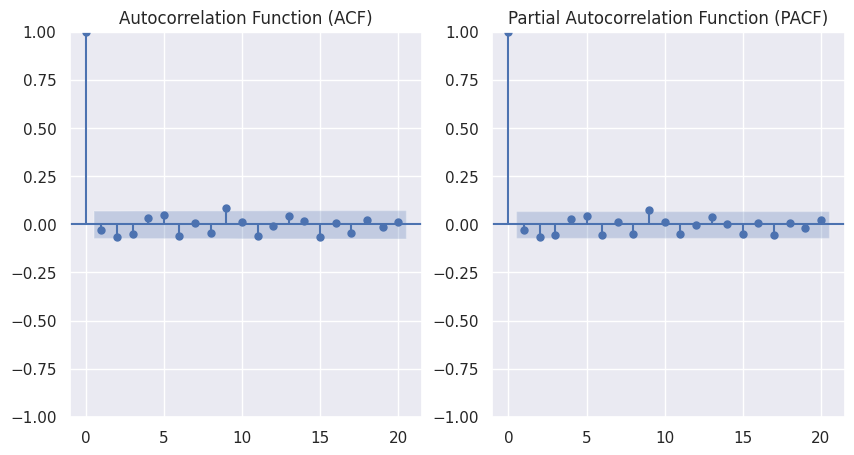

In [5]:
fig, axs = plt.subplots(1, 2)
plot_acf(msft_diff, title='Autocorrelation Function (ACF)', lags=20, ax=axs[0])
plot_pacf(msft_diff, title='Partial Autocorrelation Function (PACF)', lags=20, ax=axs[1])
plt.show()

#### 3.3.4 Auto-ARIMA Parameter Selection
Since the ACF and PACF plots above were inconclusive,  
We will try a computational method to select the optimal p and q orders.

In [6]:
mod_can_auto = auto_arima(
    msft, stepwise=False,
    start_p=0,
    start_d=1,
    start_q=0,
    max_p=10,
    max_d=3,
    max_q=10,
    trace=True,
    with_intercept=False,
    return_valid_fits=True,
)

 ARIMA(0,1,0)(0,0,0)[1]             : AIC=4510.422, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1]             : AIC=4511.854, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[1]             : AIC=4510.958, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[1]             : AIC=4511.527, Time=0.17 sec
 ARIMA(0,1,4)(0,0,0)[1]             : AIC=4512.497, Time=0.13 sec
 ARIMA(0,1,5)(0,0,0)[1]             : AIC=4513.277, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[1]             : AIC=4511.926, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[1]             : AIC=4511.887, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[1]             : AIC=4512.434, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[1]             : AIC=4513.247, Time=0.18 sec
 ARIMA(1,1,4)(0,0,0)[1]             : AIC=4514.086, Time=0.23 sec
 ARIMA(2,1,0)(0,0,0)[1]             : AIC=4511.036, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[1]             : AIC=4512.183, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[1]             : AIC=4507.372, Time=0.69 sec
 ARIMA(2,1,3)(0,0,0)[1]             : AIC=4506.124, Time=0.70 sec
 ARIMA(3,1

#### 3.3.5 Running the Model
From the above sections, we have concluded that the **ARIMA(2,1,3)** model is the most suitable.
Thus, we can run the model on our time-series.  

In [23]:
model = ARIMA(msft, order=(2,1,3)).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  755
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -2247.062
Date:                Mon, 15 Jan 2024   AIC                           4506.124
Time:                        10:31:23   BIC                           4533.876
Sample:                             0   HQIC                          4516.815
                                - 755                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1493      0.043      3.444      0.001       0.064       0.234
ar.L2         -0.9361      0.041    -22.574      0.000      -1.017      -0.855
ma.L1         -0.1811      0.057     -3.193      0.0

In [35]:
type(model.forecast().values[0])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


numpy.float64

#### 3.3.6 Forecasting
Finally, we can use our model to forecast future prices of `MSFT`

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


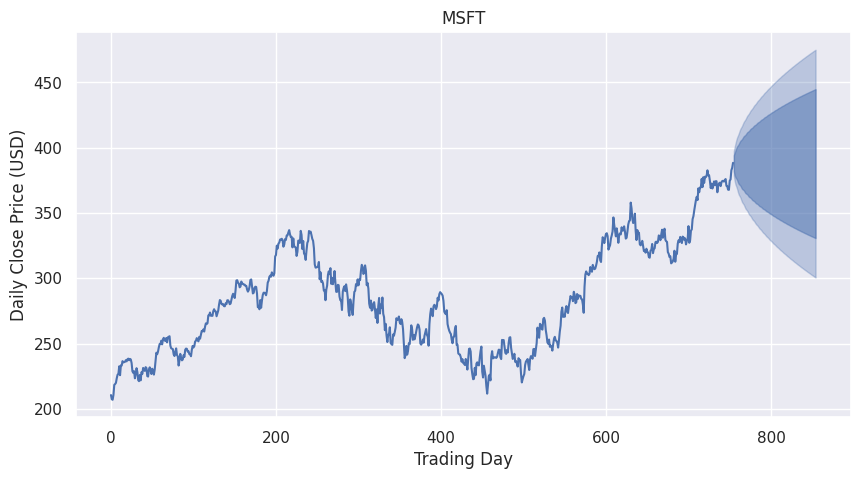

In [8]:
# forecast for the next 100 steps
forecast = model.get_forecast(steps=100)

plt.plot(msft.values)
plt.ylabel('Daily Close Price (USD)')
plt.xlabel('Trading Day')
plt.title('MSFT')

forecast_mean = np.exp(forecast.predicted_mean)  # mean of forecast data



conf_int95 = forecast.conf_int(alpha=0.05) #95% confidence interval
plt.fill_between(
    conf_int95.index,
    conf_int95["lower Close"],
    conf_int95["upper Close"],
    color="b",
    alpha=0.3,
)

conf_int80 = forecast.conf_int(alpha=0.2) #80% confidence interval
plt.fill_between(
    conf_int80.index,
    conf_int80["lower Close"],
    conf_int80["upper Close"],
    color="b",
    alpha=0.5,
)



plt.show()

### 3.4 Diagram
We'll show some plots which we used in selecting the ARIMA model above.

#### 3.4.1 Stationary Plots
We can plot the raw and difference time-series of `MSFT` to see if there are any trends which would make it non-stationary.  
The raw time-series evidently has trends up and down, and thus is non-stationary as corroborated with ADF above.  
The difference time-series conversely has no trends and just oscillates around zero, making it possibly stationary.

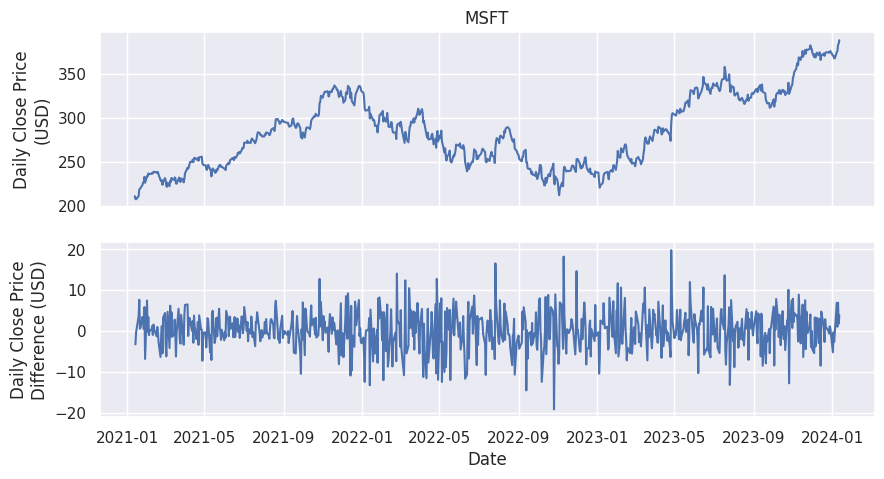

In [9]:
fig, axs = plt.subplots(2, sharex=True)

axs[0].plot(msft)
axs[0].set_ylabel('Daily Close Price\n(USD)')
axs[0].set_title('MSFT')


axs[1].plot(msft.diff()[1:])
axs[1].set_ylabel('Daily Close Price\nDifference (USD)')
axs[1].set_xlabel('Date')

plt.show()

#### 3.4.2 Model Parameters selection plots
As demonstrated above, we plotted the ACF and PACF to check for autocorrelation in our data.  
This was in hopes that it would help decide which AR and MA orders to use for our ARIMA model.

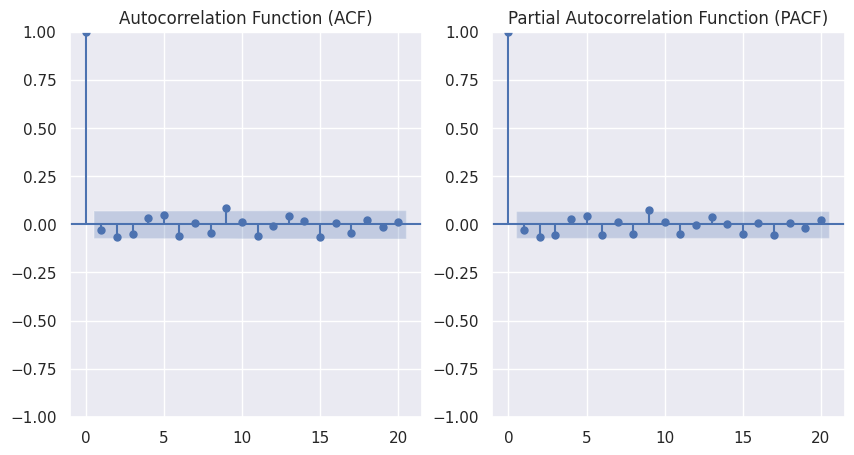

In [10]:
fig, axs = plt.subplots(1, 2)
plot_acf(msft_diff, title='Autocorrelation Function (ACF)', lags=20, ax=axs[0])
plot_pacf(msft_diff, title='Partial Autocorrelation Function (PACF)', lags=20, ax=axs[1])
plt.show()

### 3.5 Diagnosis
We can plot several diagnostic plots to validate our model.  

From each of the cells below, we can see that:  
- The residuals of our model are mostly normally distributed about zero. However, it is slightly heavy-tailed.
- There is no leftover autocorrleation that is not captured by our model.

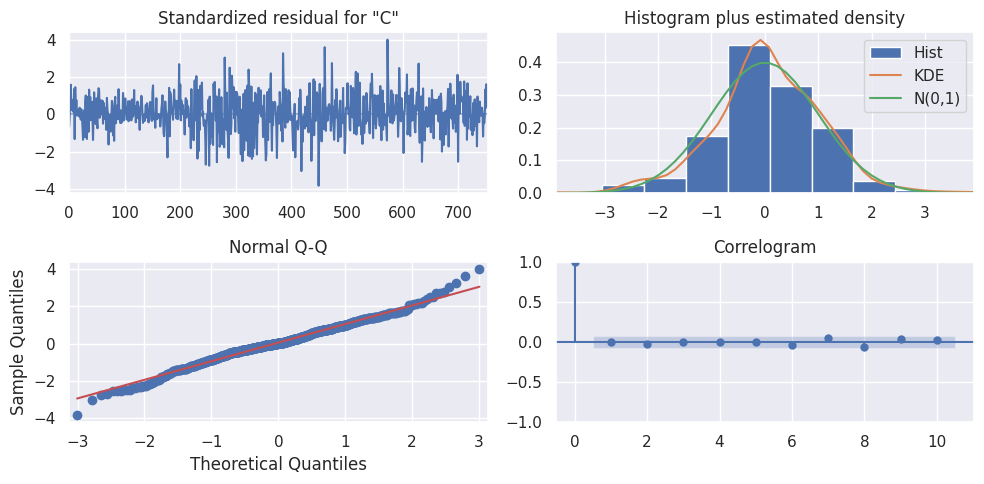

In [11]:
model.plot_diagnostics()
plt.tight_layout()
plt.show()

### 3.6 Damage
However, there are still some issues that are not fully modelled by our ARIMA model.

1. The orders of AR and MA are not clear, from our ACF, PACF and Auto-ARIMA code.  
   The chosen ARIMA(2,1,3) model was only marginally better than those of similar AR and MA orders.
2. The residuals from our model have heavy-tails, which suggests high probability of large deviations from our model.
3. There is arguably still some hetereoscedascity in our first-differenced time-series, even though it passed the ADF test.  
   Specifically, the time-series visually seemed to become more volatile after September 2021.


### 3.7 Directions

- We can try fitting the ARIMA model for shorter time horizon.  
  As highlighted previously, we noticed that the time-series seemed to become more volatile after September 2021.  
  Thus, we can try fitting our model only on later data points, in hopes that the data is more homoscedastic and stationary.
- We can also try fitting the model to finer time-series with shorter intervals.  
  Since datapoints within the same trading day might be more autocorrelated with each other and more suitable for ARIMA.

## 4. Backtesting the results

### Simulating buying & selling stocks using ARIMA

In [57]:
from tqdm import tqdm
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings

warnings.filterwarnings('ignore', category=ValueWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [58]:
def run_simulation(returns, prices, amt, order, thresh, verbose=False, plot=True):
    if type(order) == float:
        thresh = None

    curr_holding = False
    events_list = []
    init_amt = amt

    #go through dates
    for date, r in tqdm (returns.iloc[14:].items(), total=len(returns.iloc[14:])):
        #if you're currently holding the stock, sell it
        if curr_holding:
            sell_price = prices.loc[date]
            curr_holding=False
            ret = (sell_price-buy_price)/buy_price
            amt *= (1+ret)
            events_list.append(('s', date, ret))

            if verbose:
                print('Sold at $%s'%sell_price)
                print('Predicted Return: %s'%round(pred,4))
                print('Actual Return: %s'%(round(ret, 4)))
                print('=======================================')
            continue

        #get data till just before current date
        curr_data = returns[:date]


        if type(order) == tuple:
            try:
                #fit model
                model = ARIMA(curr_data, order=order).fit()

                #get forecast
                pred = model.forecast().values[0]


            except:
                pred = thresh - 1
                #print("error")



        #if you predict a high enough return and not holding, buy stock
        if (not curr_holding) and \
        ((type(order) == float and np.random.random() < order)
         or (type(order) == tuple and pred > thresh)
         or (order == 'last' and curr_data[-1] > 0)):

            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
            if verbose:
                print('Bought at $%s'%buy_price)

    if verbose:
        print('Total Amount: $%s'%round(amt,2))

    #graph
    if plot:

        plt.figure(figsize=(10,4))
        plt.plot(prices[14:])

        y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
        shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)

        for idx, event in enumerate(events_list):
            plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'green' if event[2] > 0 else 'red'
                plt.fill_betweenx(range(*shaded_y_lims),
                                  event[1], events_list[idx-1][1], color=color, alpha=0.1)

        tot_return = round(100*(amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title("%s Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s"%(tickerSymbol, thresh, round(amt,2), tot_return), fontsize=20)
        plt.ylim(*y_lims)
        plt.show()

    return amt

### 4.1 Baseline Model - Random Testing

100%|██████████| 740/740 [00:00<00:00, 11391.63it/s]


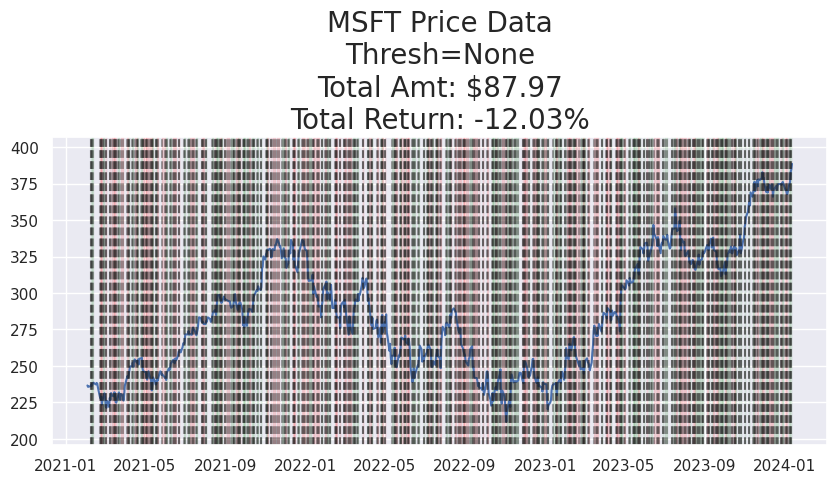

87.97029718470478

In [59]:
returns = msft.pct_change().dropna()
tickerSymbol = 'MSFT'
run_simulation(returns, msft, 100, 0.5, None, verbose=False)


100%|██████████| 740/740 [00:00<00:00, 11846.96it/s]


Text(0.5, 1.0, 'Avg: $120.39\nSD: $25.74')

<Figure size 1000x400 with 0 Axes>

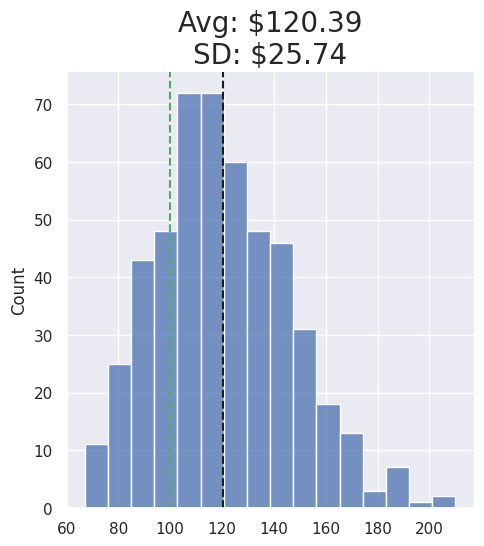

In [60]:
final_amts = [run_simulation(returns, msft, 100, 0.5, None, verbose=False, plot=False) for _ in range(500)]

plt.figure(figsize=(10,4))
sns.displot(final_amts)
plt.axvline(np.mean(final_amts), color='k', linestyle='--')
plt.axvline(100, color='g', linestyle='--')
plt.title('Avg: $%s\nSD: $%s'%(round(np.mean(final_amts),2), round(np.std(final_amts),2)), fontsize=20)

### 4.2 ARIMA Model

  0%|          | 0/740 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
  0%|          | 1/740 [00:00<02:16,  5.41it/s]/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
  2%|▏         | 15/740 [00:01<01:20,  9.05it/s]/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Usi

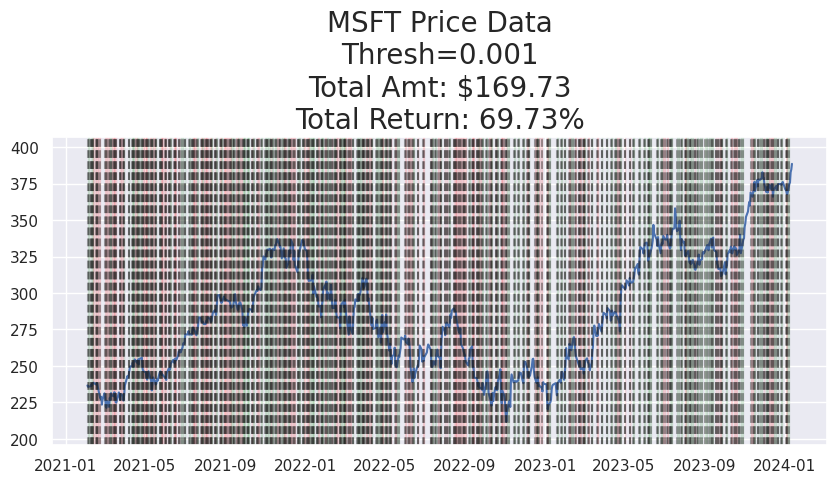

169.73079480995025

In [61]:
run_simulation(returns, msft, 100, (2,0,3), 0.001, verbose=False)

We can see our ARIMA model performs better than a Random Baseline Model on 3 year timeframe.

## References
- Aroussi, Ran. “Yfinance: Yahoo! Finance Market Data Downloader.” PyPI, 2023,
https://pypi.org/project/yfinance/.
- Yahoo Finance. “Yahoo Finance - Business Finance, Stock Market, Quotes, News.”
Yahoo Finance, https://finance.yahoo.com/.
- Duke University. "Identifying the Order of Differencing in an ARIMA Model.", https://people.duke.edu/~rnau/411arim2.htm